# Figure Notebook

In [1]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import my_shell_tools

# analysis
from scipy.stats import ttest_ind_from_stats
import itertools

# geomip_data
import os.path
# import cf
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
"""
Import all from projects python scripts
"""

from gfdl_data import *
from get_glens_data import *
from analysis import *
from plotting import *

In [3]:
"""
How much of this needed?
"""

# Directory and filenames for annual timeseries of 2D data
glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_template = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'

vars_glens = ['TREFHT','TREFHTMX','P-E','PRECTMX']
exps_glens = ['control','feedback']
years = ['2010-2029','2075-2094']

# year ranges which appears in filename
control_file_years = '201001-209912'
control_short_file_years = '201001-203012'
feedback_file_years = '202001-209912'

seas = 'ann'
stats = ['mean','std']

"""
Specify years of experiments and associated indices for annual files
"""

years_control = np.array([IDX + 2010 for IDX in range(90)])
years_feedback = np.array([IDX + 2020 for IDX in range(80)])

#Generate the indices for the range of years in each case.
# [0] added as a 2 element tuple with an array and an empty slot returned rather than an array
t_index_control = np.where((years_control > 2074) & (years_control < 2095))[0]
t_index_baseline = np.where((years_control > 2009) & (years_control < 2030))[0]
t_index_feedback = np.where((years_feedback > 2074) & (years_feedback < 2095))[0]

"""
How much of this needed?
"""

'\nHow much of this needed?\n'

In [4]:
"""
Generate means and stds for all variables and cases
"""

# get lons, lats and weights
lons, lats, weights = get_lons_lats_weights()

# returnes (Means, Stds) for all cases and vars
all_data = get_all_cases_vars() # {(var,case)}
"""
CASES:
'Baseline'     - RCP8.5 @ 2010-2029
'RCP8.5'       - RCP8.5 @ 2075-2094
'Full-GLENS'   - GLENS  @ 2075-2094
'Half-GLENS'   - Scaled Half-GLENS  @ 2075-2094
'Baseline-2'   - RCP8.5 @ 2010-2029 W/ alternate runs
'Full-GLENS-2'   - GLENS @ 2075-2094 W/ alternate runs
'Half-GLENS-2'   - Scaled Half-GLENS @ 2075-2094 W/ alternate runs on GLENS (not on RCP8.5)
### NOT DONE ### 'Half-GLENS-time' - Shifted Half-GLENS @ 2075-2094 AND ?????
"""

# get weights and masks
all_masks = get_glens_masks_weights() # all_masks[masks]
"""
MASKS:
'land_mask' - binary land mask where land fraction > 50%
'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
WEIGHTS:
'pop' - gridcell weighting by population fraction
'ag' - gridcell weighting by agricultural land fraction
'area' - simple gridcell weighting by area
'land_area' - land area weighting using raw land area fraction (not mask)
'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
"""


"\nMASKS:\n'land_mask' - binary land mask where land fraction > 50%\n'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%\nWEIGHTS:\n'pop' - gridcell weighting by population fraction\n'ag' - gridcell weighting by agricultural land fraction\n'area' - simple gridcell weighting by area\n'land_area' - land area weighting using raw land area fraction (not mask)\n'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)\n"

In [5]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

# color guide here: https://www.w3schools.com/colors/colors_picker.asp
# color blender here: https://meyerweb.com/eric/tools/color-blend
red = '#ff0000'
l_red = '#ffc0c0' # old: '#ffd9d9'
blue = '#0066ff'
l_blue = '#c0c0ff' # old:'#b2d0ff'
purple = '#803380'
l_purple = '#C099C0' 

std_alpha = 0.2

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

# INSERT FIGURE SECTIONS HERE

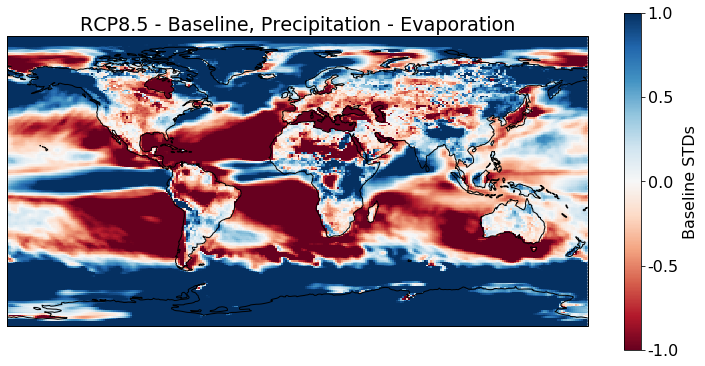

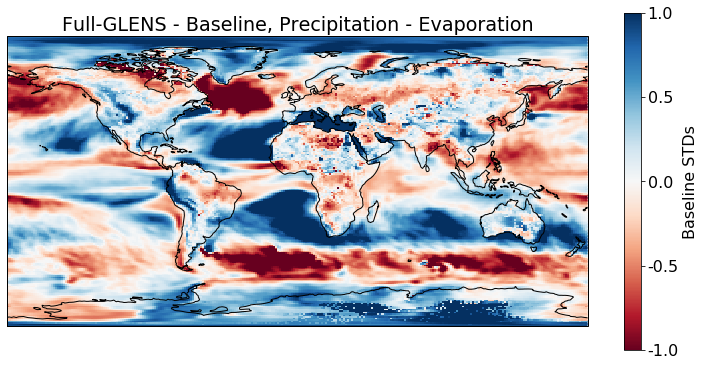

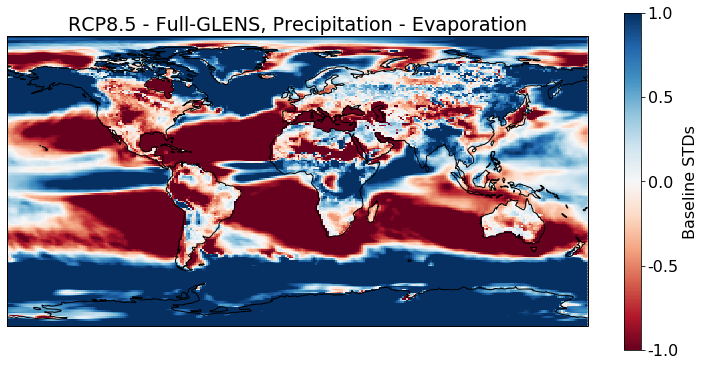

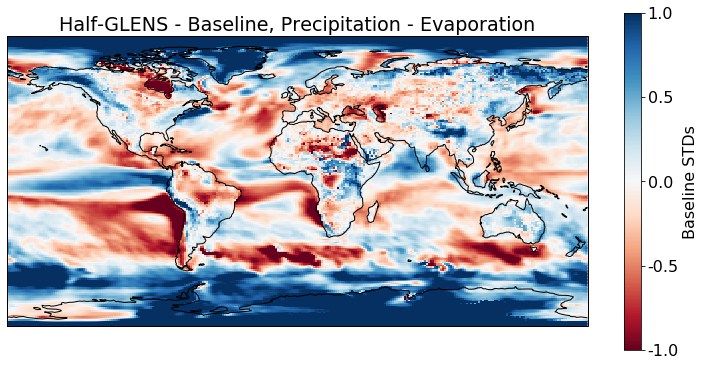

In [15]:
# %load figure_sections/map_plots.py
"""
MAP PLOTS
"""

"""
Anom Maps
"""

out_dir = '/n/home03/pjirvine/projects/GLENS_fraction_better_off/plots/'

"""
Import modules
"""

# IMPORT MODULES
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

def anom_map(data, bounds, labels, title, cbar_label, out_name=None, show=False):

    # Make CO2 anom figure
    fig = plt.figure(figsize=(13,6.2))

    plt.rcParams.update({'font.size': 16})

    ax = plt.subplot(111, projection=ccrs.PlateCarree())

    data_cyc, lons_cyc = add_cyclic_point(data, coord=lons)
    lons2d_cyc, lats2d = np.meshgrid(lons_cyc, lats)

    mm = ax.pcolormesh(lons2d_cyc, lats2d, data_cyc, vmin=bounds[0], vmax=bounds[-1],
                       transform=ccrs.PlateCarree(),cmap='RdBu' )
    ax.coastlines()

    plt.title(title)

    cbar = fig.colorbar(mm, ax=ax, ticks=bounds)
    cbar.set_ticklabels(labels)
    cbar.set_label(cbar_label)

    # fig.subplots_adjust(right=0.85)
    # # add_axes defines new area with: X_start, Y_start, width, height
    # cax = fig.add_axes([0.85,0.53,0.03,0.35])

    if out_name is not None:
        plt.savefig(out_dir+out_name+'.png', format='png', dpi=600)
        plt.savefig(out_dir+out_name+'.eps', format='eps', dpi=600)

    if show:
        plt.show()
#end def

"""
Anom map set function
"""

def anom_map_set(all_data, var, var_title, anom_type, cbar_label, bounds, labels, cmap=None):
    cases = ['Full-GLENS','RCP8.5','Baseline']
    sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, nyears=80, ttest_level=0.1, anom_type=anom_type)
    # get data for HALF-GLENS
    cases = ['Half-GLENS','RCP8.5','Baseline']
    half_sg_anom, CO2_anom, half_sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, nyears=80, ttest_level=0.1, anom_type=anom_type)

    # Produce plots
    title = 'RCP8.5 - Baseline, ' + var_title
    out_name = 'RCP8.5_'+var+'_'+anom_type+'_anom'
    anom_map(CO2_anom.transpose(), bounds, labels, title, cbar_label, out_name=out_name, show=True)

    title = 'Full-GLENS - Baseline, ' + var_title
    out_name = 'Full-GLENS_'+var+'_'+anom_type+'_anom'
    anom_map(sg_anom.transpose(), bounds, labels, title, cbar_label, out_name=out_name, show=True)

    # Note this is inverted!
    title = 'RCP8.5 - Full-GLENS, ' + var_title
    out_name = 'RCP8.5-Full-GLENS_'+var+'_'+anom_type+'_anom'
    anom_map(-1. * sg_CO2_anom.transpose(), bounds, labels, title, cbar_label, out_name=out_name, show=True)

    title = 'Half-GLENS - Baseline, ' + var_title
    out_name = 'Half-GLENS_'+var+'_'+anom_type+'_anom'
    anom_map(half_sg_anom.transpose(), bounds, labels, title, cbar_label, out_name=out_name, show=True)
#end def

"""
Produce Anom Maps
"""

out_dir = '/n/home03/pjirvine/projects/GLENS_fraction_better_off/plots/'

weight = all_masks['area']

var = 'P-E'
var_title = 'Precipitation - Evaporation'
anom_type = 'SD'
cbar_label = 'Baseline STDs'
bounds = [-1,-0.5,0,0.5,1.0]
labels = ["{:2.1f}".format(IDX) for IDX in bounds]
cmap = None

anom_map_set(all_data, var, var_title, anom_type, cbar_label, bounds, labels, cmap=None)


In [9]:
"""
Efficacy map function
"""

def eff_map(data, bounds, labels, title, cbar_label, mask, mask_threshold=0.27, out_name=None, show=False):
    """
    mask threshold: 0.27 = 90% T-Test, 0.32 = 95% T-Test
    """

    """
    Define new colormap
    """

    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    rdylgn_1 = cm.get_cmap('RdYlGn', 200)
    rdylgn_2 = cm.get_cmap('RdYlGn', 200)
    rdbu = cm.get_cmap('PRGn', 200)

    color_a = rdylgn_1(np.linspace(0, 1, 200))
    color_b = rdylgn_2(np.linspace(0, 1, 200))
    color_c = rdbu(np.flip(np.linspace(0, 1, 200)))

    color_list = [color_b[-1], (0.8, 0.8, 1), color_c[-1]]
    cmap_from_list = LinearSegmentedColormap.from_list('my_colors', color_list, N=200)
    color_d = cmap_from_list(np.linspace(0, 1, 200))

    newcolors = np.vstack((color_a[0:100], color_b[100:200], color_d))
    newcmp = ListedColormap(newcolors, name='spectral_pete')

    """
    make plot
    """

    fig = plt.figure(figsize=(13,6.2))

    plt.rcParams.update({'font.size': 16})

    ax = plt.subplot(111, projection=ccrs.PlateCarree())

    data_cyc, lons_cyc = add_cyclic_point(data, coord=lons)
    mask_cyc, lons_cyc = add_cyclic_point(mask, coord=lons)
    lons2d_cyc, lats2d = np.meshgrid(lons_cyc, lats)

    masked_data = np.ma.array(data_cyc,mask=abs(mask_cyc) < mask_threshold)

    mm = ax.pcolormesh(lons2d_cyc, lats2d, masked_data, vmin=bounds[0], vmax=bounds[-1],
                       transform=ccrs.PlateCarree(),cmap=newcmp )
    ax.coastlines()

    plt.title(title)

    cbar = fig.colorbar(mm, ax=ax, ticks=bounds)
    cbar.set_ticklabels(labels)
    cbar.set_label(cbar_label)

    # fig.subplots_adjust(right=0.85)
    # # add_axes defines new area with: X_start, Y_start, width, height
    # cax = fig.add_axes([0.85,0.53,0.03,0.35])

    if out_name is not None:
        plt.savefig(out_dir+out_name+'.png', format='png', dpi=600)
        plt.savefig(out_dir+out_name+'.eps', format='eps', dpi=600)

    if show:
        plt.show()
#end def   
"""
Efficacy Map example
"""

# Set cases, var and get data
cases = ['Full-GLENS','RCP8.5','Baseline']
var = 'PRECTMX'
weight = all_masks['area']
# get SD anoms
sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, nyears=80, ttest_level=0.1, anom_type='SD')

eff = -1. * (sg_CO2_anom / CO2_anom)

data = eff.transpose()
mask = CO2_anom.transpose()

bounds = [-1, -0.5, 0., 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
labels = [str(IDX) for IDX in bounds]
title = var+' GLENS Efficacy'
cbar_label = 'Efficacy (ratio)'
out_name = var+'_eff_map' 

eff_map(data, bounds, labels, title, cbar_label, mask, mask_threshold=0.27, out_name=out_name, show=False)

# Loading Example NetCDF to see contents and map results

In [ ]:
"""
Example netcdf file of annual series + gather lons and lats
"""

"""
variables(dimensions): float64 time(time), float64 time_bnds(time,bnds), 
    float64 lat(lat), float64 lon(lon), float64 gw(lat), float64 ch4vmr(time), 
    float64 co2vmr(time), int32 ndcur(time), int32 date(time), int32 nscur(time), 
    float64 sol_tsi(time), int32 nsteph(time), float64 f11vmr(time), float64 n2ovmr(time), 
    int32 datesec(time), float64 f12vmr(time), float32 TREFHT(time,lat,lon)
"""

var='TREFHT'
exp='control'
run='001'
file_years='201001-209912'

glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_filename = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'.format(exp=exp,run=run,var=var,years=file_years)

glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)

lons = np.array(test_nc.variables['lon'][:])
lats = np.array(test_nc.variables['lat'][:])

# grid-weights by latitude
gw = test_nc.variables['gw'][:]
gw_2D = np.tile(gw, (lons.size,1))
gw_2D = gw_2D / np.sum(gw_2D)

In [14]:
# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

fix_dir = '/n/home03/pjirvine/keithfs1_pji/geomip_archive/final_data/CCSM4/fix/'
filename = 'sftlf_CCSM4.nc'
test_nc = Dataset(fix_dir + filename)

nc_data = test_nc.variables['sftlf'][:].transpose()

In [15]:
nc_data.shape

(288, 192)

In [ ]:
    """
    MASKS:
    'land_mask' - binary land mask where land fraction > 50%
    'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    WEIGHTS:
    'pop' - gridcell weighting by population fraction
    'ag' - gridcell weighting by agricultural land fraction
    'area' - simple gridcell weighting by area
    'land_area' - land area weighting using raw land area fraction (not mask)
    'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
    """

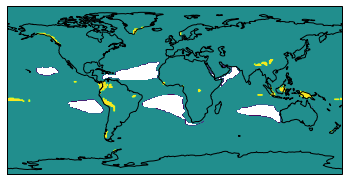

masked_array(
  data=[[86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        ...,
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [31]:
"""
Example cartopy plot

http://earthpy.org/tag/cartopy.html
https://scitools.org.uk/cartopy/docs/v0.16/matplotlib/advanced_plotting.html
"""

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs

from cartopy.util import add_cyclic_point

# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

# nc_data = test_nc.variables['TREFHT'][:].transpose()
# data = np.mean(nc_data,2)

# data = all_masks['land_noice_mask'].transpose()

data = all_data[('P-E','Baseline')][0]

ax = plt.axes(projection=ccrs.PlateCarree())

# plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

lons2d, lats2d = np.meshgrid(lons, lats)

plt.contourf(lons2d, lats2d, data.transpose(), 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

# fig.colorbar(cm.ScalarMappable(),ax=ax)

plt.show()

data

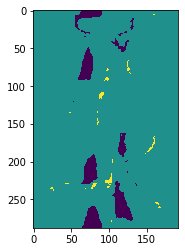

In [26]:
plt.imshow(all_data[('P-E','RCP8.5')][0])